# Grover's Algorithm

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import  MCXGate
import numpy as np

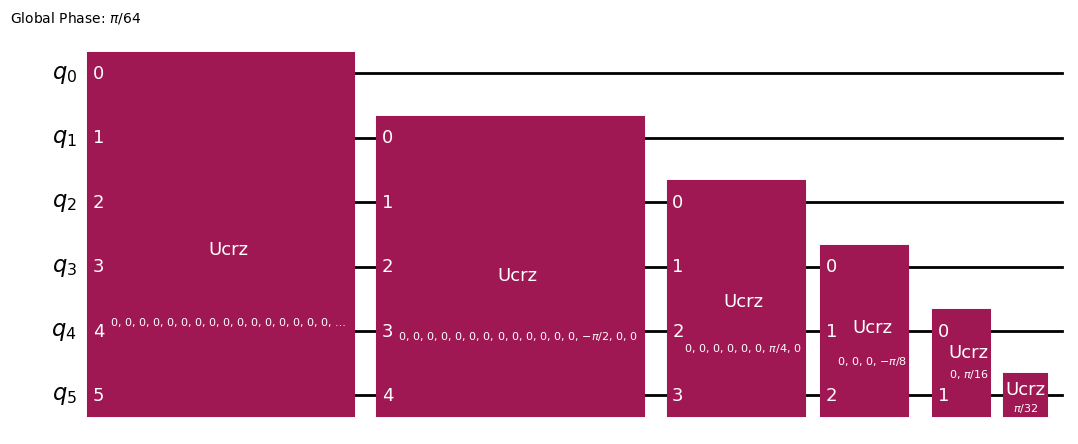

In [2]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import AmplificationProblem
import random

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc
    
n = 6
state = ''.join(random.choice(['0','1']) for i in range(n))
pre_oracle = Statevector.from_label(state)
oracle = AmplificationProblem(pre_oracle, is_good_state=state)
oracle = oracle.grover_operator.oracle.decompose()
oracle.draw('mpl')


In [9]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    mcx_gate = MCXGate(nqubits-1)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.append(mcx_gate,range(nqubits))
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    return qc


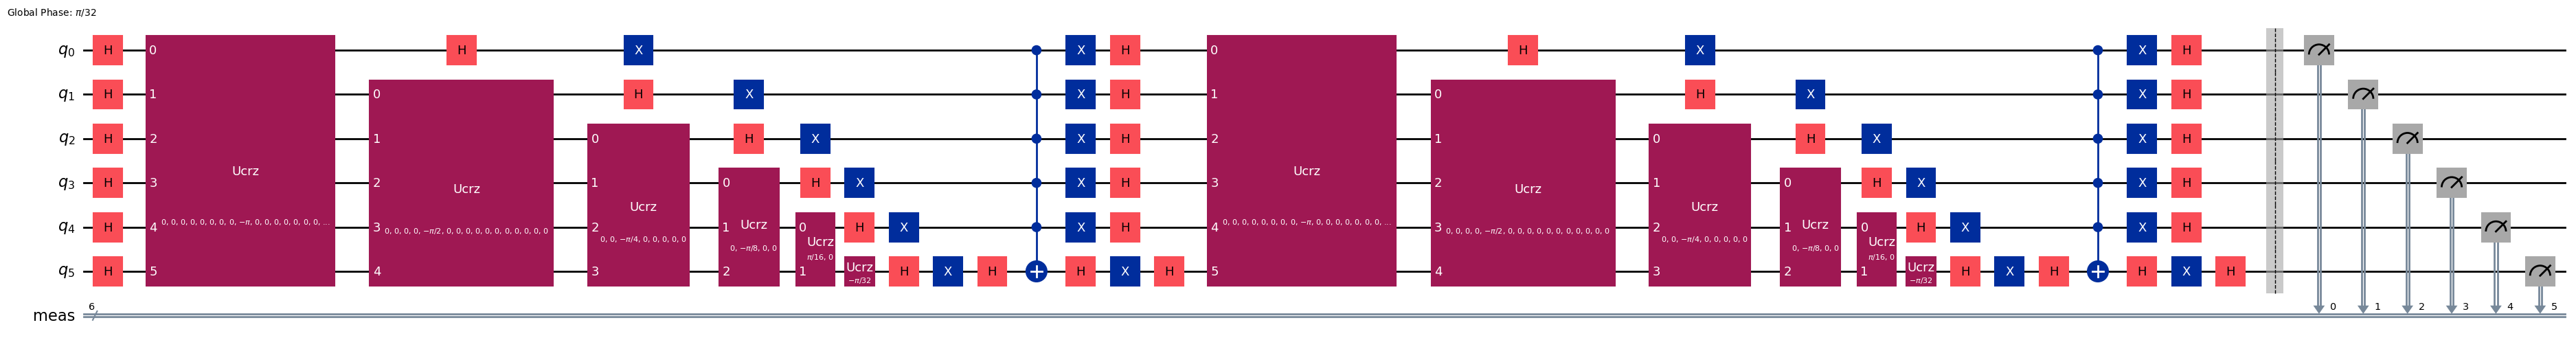

In [10]:
t =2 
circuit = QuantumCircuit(n)
#oracle = Oracle(n)
for i in range(n):
     circuit.h(i)
for s in range(t):
     circuit&=oracle
     circuit&=diffuser(n)
circuit.measure_all()
circuit.draw('mpl',fold=-1)

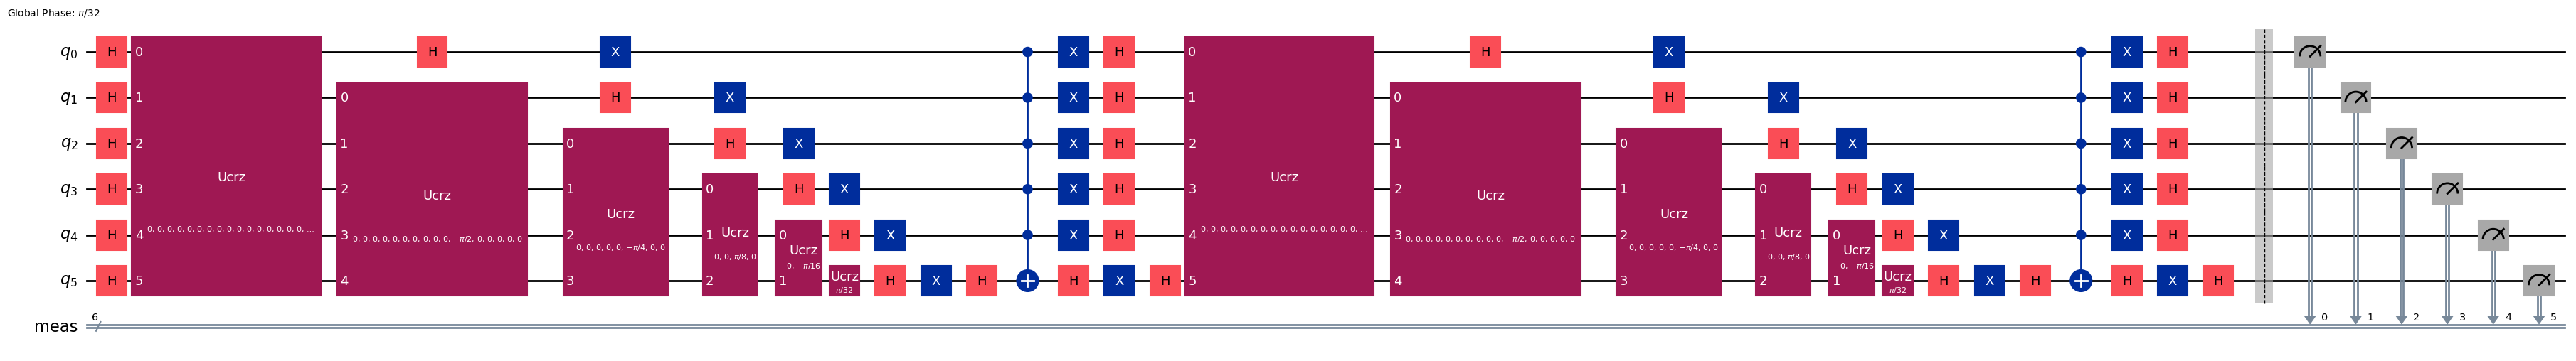

In [47]:
depth = 10
grover_circuit = [0]*depth
for i in range(depth):
    grover_circuit[i] = QuantumCircuit(n)
    grover_circuit[i] = initialize_s(grover_circuit[i], range(n))
    for t in range(i+1):
        grover_circuit[i] &= oracle
        grover_circuit[i] &= diffuser(n)
    grover_circuit[i].measure_all()
grover_circuit[1].draw('mpl',fold=-1)

101000
150


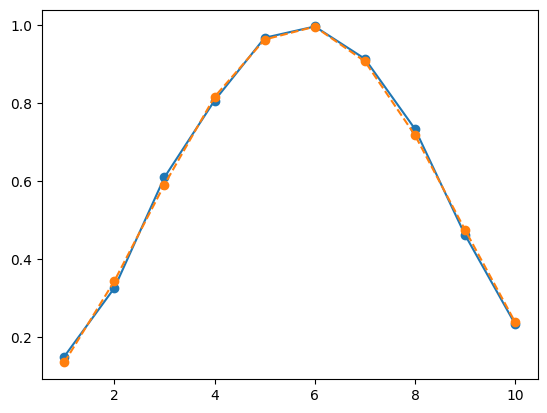

In [48]:
from qiskit_aer import AerSimulator
aersim = AerSimulator()
result = [0]*depth
for i in range(depth):
    qct = transpile(grover_circuit[i], aersim)
    result[i] = aersim.run(qct, shots=1000).result()
#print(result[0].get_counts().most_frequent())
print(state)
print(result[0].get_counts()[state])
prob = np.zeros(depth)
for i in range(depth):
    if state in result[i].get_counts():
        prob[i] = result[i].get_counts()[state]/1000
import matplotlib.pyplot as plt
theta = 2*np.arcsin(1./np.sqrt(2**n))
t = np.linspace(1,depth,depth)
proba = np.sin((2*t+1)*theta/2.)**2
plt.plot(t,prob,'-o',t,proba,'--o')

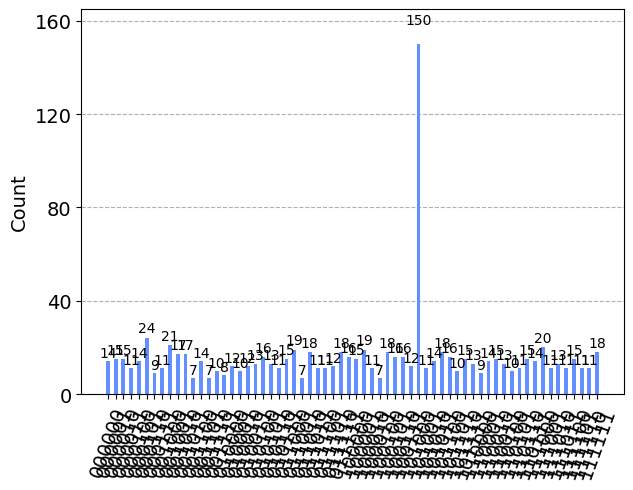

In [53]:
plot_histogram(result[0].get_counts())

In [62]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token='4a16726728442fbaf62ce53c563550eec8e77fa305d83d195abbf8016e53b46ba4f20217097c0937715c88f3aa51a88b44f30b404b0253f742650414770fe9fe',overwrite=True)

In [63]:
from qiskit_ibm_provider import least_busy
from qiskit_ibm_provider import IBMProvider
#IBMProvider.load_account()
provider = IBMProvider(instance='ibm-q/open/main')
#provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-grenoble-alpe-1', project='ibmq-quantum-pr')
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#backend = provider.get_backend('ibmq_quito')


#provider = IBMQ.get_provider("ibm-q")
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
#backend = provider.backends.ibmq_lima
print(backend)


<IBMBackend('ibm_brisbane')>


In [66]:
#qobj = assemble(transpile(qc, backend=backend), backend=backend)
#job = backend.run(qobj)
# Grab the results from the job.
#from qiskit.tools.monitor import job_monitor

shots = 1024
circ = transpile(grover_circuit[0],backend=backend)
job = backend.run(circ, shots=shots)

#job_monitor(job, interval = 2)

In [ ]:
results = job.result()
print(results)
answer = results.get_counts()


plot_histogram(answer)